# CNN – Classification Dogs vs Cats

Objectif : entraîner un CNN pour une classification binaire
et analyser l’impact du nombre de convolutions.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import os
import time
import GPUtil
import psutil

In [43]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 20

In [44]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_set = train_gen.flow_from_directory(
    "../dataset/training_set",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_set = test_gen.flow_from_directory(
    "../dataset/test_set",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [45]:
def build_cnn(nb_conv):
    model = Sequential()

    # 1ère convolution
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)))
    model.add(MaxPooling2D((2,2)))

    # 2ème convolution
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

    # 3ème convolution OPTIONNELLE
    if nb_conv == 3:
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(MaxPooling2D((2,2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [46]:
def get_cpu_ram():
    cpu_percent = psutil.cpu_percent(interval=1)
    ram = psutil.virtual_memory()
    ram_used_mb = ram.used / (1024 ** 2)
    return cpu_percent, ram_used_mb
def get_gpu_stats():

    try:
        gpus = GPUtil.getGPUs()
        if not gpus:
            return None, None, None
        gpu = gpus[0]
        return gpu.load * 100, gpu.memoryUsed, gpu.memoryTotal
    except:
        return None, None, None

In [47]:
class PerformanceCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        cpu, ram = get_cpu_ram()
        gpu, vram_used, vram_total = get_gpu_stats()
        duration = time.time() - self.start_time

        msg = f" | CPU: {cpu:.1f}% | RAM: {ram:.0f} MB | Time: {duration:.1f}s"
        if gpu is not None:
            msg += f" | GPU: {gpu:.1f}% | VRAM: {vram_used}/{vram_total} MB"
        print(msg)


def get_callbacks(nb_conv):
    ckpt_dir = f"checkpoints_cnn_{nb_conv}"
    os.makedirs(ckpt_dir, exist_ok=True)

    checkpoint = ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "weights_epoch_{epoch:02d}.h5"),
        monitor="val_loss",
        save_weights_only=True,
        save_best_only=False,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    return checkpoint, early_stop, ckpt_dir

In [48]:
model_2 = build_cnn(nb_conv=2)

checkpoint, early_stop, ckpt_dir = get_callbacks(2)

history_2 = model_2.fit(
    train_set,
    steps_per_epoch=train_set.samples // BATCH_SIZE,
    epochs=20,
    validation_data=test_set,
    validation_steps=test_set.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stop, PerformanceCallback()],
    verbose=1
)

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.5564
Epoch 1: saving model to checkpoints_cnn_2\weights_epoch_01.h5
 | CPU: 4.6% | RAM: 15655 MB | Time: 14.0s | GPU: 30.0% | VRAM: 764.0/16303.0 MB
250/250 [==============================] - 14s 56ms/step - loss: 0.6836 - accuracy: 0.5564 - val_loss: 0.6417 - val_accuracy: 0.6028
Epoch 2/20
249/250 [============================>.] - ETA: 0s - loss: 0.6052 - accuracy: 0.6711
Epoch 2: saving model to checkpoints_cnn_2\weights_epoch_02.h5
 | CPU: 3.6% | RAM: 15688 MB | Time: 12.1s | GPU: 42.0% | VRAM: 764.0/16303.0 MB
250/250 [==============================] - 12s 48ms/step - loss: 0.6051 - accuracy: 0.6712 - val_loss: 0.5606 - val_accuracy: 0.7233
Epoch 3/20
249/250 [============================>.] - ETA: 0s - loss: 0.5646 - accuracy: 0.7101
Epoch 3: saving model to checkpoints_cnn_2\weights_epoch_03.h5
 | CPU: 2.7% | RAM: 15681 MB | Time: 12.1s | GPU: 2.0% | VRAM: 774.0/16303.0 MB
250/250 [======

In [49]:
model_3 = build_cnn(nb_conv=3)

checkpoint, early_stop, ckpt_dir = get_callbacks(3)

history_3 = model_3.fit(
    train_set,
    steps_per_epoch=train_set.samples // BATCH_SIZE,
    epochs=20,
    validation_data=test_set,
    validation_steps=test_set.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stop, PerformanceCallback()],
    verbose=1
)


Epoch 1/20
249/250 [============================>.] - ETA: 0s - loss: 0.6688 - accuracy: 0.5833
Epoch 1: saving model to checkpoints_cnn_3\weights_epoch_01.h5
 | CPU: 1.9% | RAM: 15724 MB | Time: 12.2s | GPU: 7.0% | VRAM: 781.0/16303.0 MB
250/250 [==============================] - 12s 48ms/step - loss: 0.6691 - accuracy: 0.5831 - val_loss: 0.5921 - val_accuracy: 0.6951
Epoch 2/20
249/250 [============================>.] - ETA: 0s - loss: 0.6036 - accuracy: 0.6679
Epoch 2: saving model to checkpoints_cnn_3\weights_epoch_02.h5
 | CPU: 2.7% | RAM: 15732 MB | Time: 11.9s | GPU: 5.0% | VRAM: 781.0/16303.0 MB
250/250 [==============================] - 12s 48ms/step - loss: 0.6032 - accuracy: 0.6681 - val_loss: 0.5703 - val_accuracy: 0.7107
Epoch 3/20
249/250 [============================>.] - ETA: 0s - loss: 0.5748 - accuracy: 0.6963
Epoch 3: saving model to checkpoints_cnn_3\weights_epoch_03.h5
 | CPU: 2.4% | RAM: 15729 MB | Time: 11.8s | GPU: 2.0% | VRAM: 833.0/16303.0 MB
250/250 [========

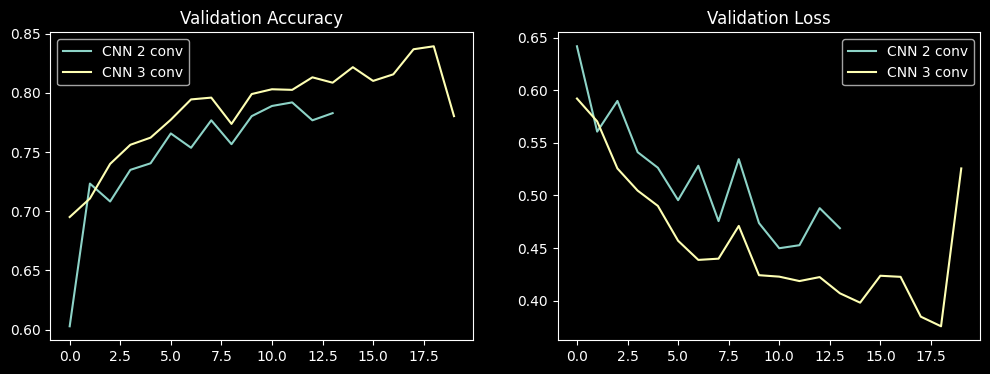

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_2.history["val_accuracy"], label="CNN 2 conv")
plt.plot(history_3.history["val_accuracy"], label="CNN 3 conv")
plt.title("Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_2.history["val_loss"], label="CNN 2 conv")
plt.plot(history_3.history["val_loss"], label="CNN 3 conv")
plt.title("Validation Loss")
plt.legend()

plt.show()


### Comparaison CNN 2 convolutions vs CNN 3 convolutions (Dogs & Cats)

L’entraînement des deux architectures montre que l’ajout d’une troisième couche de convolution améliore les performances du modèle, tout en conservant un entraînement stable et bien régularisé grâce à l’early stopping.

CNN 2 convolutions :

- Précision maximale sur l’ensemble de validation : ~79,2 %
- Perte de validation minimale : ~0,45
- Early stopping déclenché à l’epoch 14, meilleur modèle restauré à l’epoch 12

CNN 3 convolutions :

- Précision maximale sur l’ensemble de validation : ~83,9 %
- Perte de validation minimale : ~0,38
- Entraînement mené jusqu’à l’epoch 20, avec performances optimales observées entre les epochs 18 et 19

Le graphe de précision de validation montre que le CNN à 3 convolutions converge plus régulièrement et atteint une précision systématiquement supérieure à celle du CNN à 2 convolutions sur la majorité des epochs. De plus, le graphe de perte de validation indique une diminution plus marquée et plus stable pour le modèle à 3 convolutions, traduisant une meilleure capacité de généralisation.

Lors de l’entraînement des modèles CNN à 2 et 3 convolutions, l’utilisation des ressources matérielles reste faible et stable. Le CPU est peu sollicité (environ 1 à 5 %), le GPU présente une utilisation modérée avec quelques pics ponctuels (jusqu’à ~30–40 % en début d’entraînement pour le CNN à 2 convolutions), la RAM reste stable autour de 15 à 16 Go et la VRAM demeure inférieure à 1 Go. Ces observations montrent que l’entraînement n’est pas limité par le matériel et que les performances obtenues sont liées aux choix d’architecture.
